<a href="https://colab.research.google.com/github/lele25811/Vehicle-ReId/blob/main/VehicleReiD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prova implementazione CNN

* Dataset: VeRi (https://github.com/VehicleReId/VeRi)
> download from google drive: https://drive.google.com/file/d/0B0o1ZxGs_oVZWmtFdXpqTGl3WUU/view?pli=1&resourcekey=0-YIcgC3HmQD7QnvoMpmfczA

* Model: ResNet50


# 1. Download datasets

In [1]:
# Monto il mio google drive (una volta montanto il contenuto di google drive sarà accessibile nella directory `/content/drive/My Drive`)
from google.colab import drive
!mkdir -p drive/
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# Indoviduo il path del dataset
dataset_path = "/content/drive/MyDrive/datasets/VeRi.zip"

In [3]:
# Creo la cartella `data`
!mkdir -p data/

In [4]:
# Copio il file nel Workspace
!cp "/content/drive/MyDrive/datasets/VeRi.zip" /content/

In [5]:
# Controllo il tipo di file scaricato
!file VeRi.zip

VeRi.zip: Zip archive data, at least v1.0 to extract, compression method=store


In [6]:
# Decomprimo il file zip
!unzip /content/VeRi.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/VeRi/image_train/0665_c012_00062320_0.jpg  
  inflating: data/VeRi/image_train/0665_c012_00062325_0.jpg  
  inflating: data/VeRi/image_train/0665_c013_00062110_0.jpg  
  inflating: data/VeRi/image_train/0665_c013_00062115_0.jpg  
  inflating: data/VeRi/image_train/0665_c013_00062120_0.jpg  
  inflating: data/VeRi/image_train/0665_c013_00062125_0.jpg  
  inflating: data/VeRi/image_train/0665_c013_00062130_0.jpg  
  inflating: data/VeRi/image_train/0665_c013_00062135_0.jpg  
  inflating: data/VeRi/image_train/0665_c014_00063935_0.jpg  
  inflating: data/VeRi/image_train/0665_c014_00063940_0.jpg  
  inflating: data/VeRi/image_train/0665_c014_00063945_0.jpg  
  inflating: data/VeRi/image_train/0665_c014_00063950_0.jpg  
  inflating: data/VeRi/image_train/0665_c014_00063955_0.jpg  
  inflating: data/VeRi/image_train/0665_c014_00063960_0.jpg  
  inflating: data/VeRi/image_train/0665_c015_00063745_0.jpg  
  inflating: data/V

# Organizzazione Dataset

### 1. Parsing del file XML

Estraiamo le informazioni rilevanti dal file XML e le memorizziamo in un DataFrame Pandas
* train_labels_df
* test_labels_df

che contengono:
* nome immagine
* Vehicle ID
* Camera ID
* Color ID
* Type ID

In [7]:
import xml.etree.ElementTree as ET
import pandas as pd

def parse_labels(label_path):
    # Lista per memorizzare i dati
    data = []

    # Aprire il file con la codifica esplicita
    with open(label_path, "r", encoding="ascii", errors="ignore") as f:
      content = f.read() # Leggi il contenuto ignorando gli errori

      try:
        tree = ET.ElementTree(ET.fromstring(content))  # Parso direttamente il contenuto
        root = tree.getroot()  # Ottieni il nodo radice
        # Iterare attraverso i nodi Item
        for item in root.find('Items').findall("Item"):
          image_name = item.get("imageName")
          vehicle_id = item.get("vehicleID")
          camera_id = item.get("cameraID")
          color_id = item.get("colorID")
          type_id = item.get("typeID")

          # Aggiungere i dati alla lista
          data.append({
            "image_name": image_name,
            "vehicle_id": int(vehicle_id),
            "camera_id": camera_id,
            "color_id": int(color_id),
            "type_id": int(type_id)
          })
      except ET.ParseError as e:
        print(f"Errore di parsing: {e}")
        return {}

    return pd.DataFrame(data)

# Percorso al file XML
train_label_path = "/content/data/VeRi/train_label.xml"
test_label_path = "/content/data/VeRi/test_label.xml"

# Creo un dataframe per le immagini di train e test
train_labels_df = parse_labels(train_label_path)
test_labels_df = parse_labels(test_label_path)

# Recupero le dimensioni dei dataset (righe e colonne)
train_df_rows, train_df_cols = train_labels_df.shape
test_df_rows, test_df_cols = test_labels_df.shape

print(f"train dataframe -> rows: {train_df_rows}, cols: {train_df_cols}")
print(f"test dataframe -> rows: {test_df_rows}, cols: {test_df_cols}")

train dataframe -> rows: 37746, cols: 5
test dataframe -> rows: 11579, cols: 5


In [8]:
# Controlliamo i primi elementi per confermare che le colonne siano riempite correttamente
print(train_labels_df.head())
print(test_labels_df.head())

                 image_name  vehicle_id camera_id  color_id  type_id
0  0001_c001_00016450_0.jpg           1      c001         1        4
1  0001_c001_00016460_0.jpg           1      c001         1        4
2  0001_c001_00016470_0.jpg           1      c001         1        4
3  0001_c001_00016480_0.jpg           1      c001         1        4
4  0001_c001_00016490_0.jpg           1      c001         1        4
                 image_name  vehicle_id camera_id  color_id  type_id
0  0002_c002_00030600_0.jpg           2      c002         1        4
1  0002_c002_00030605_1.jpg           2      c002         1        4
2  0002_c002_00030615_1.jpg           2      c002         1        4
3  0002_c002_00030625_1.jpg           2      c002         1        4
4  0002_c002_00030640_0.jpg           2      c002         1        4


In [9]:
# Controlliamo che non ci siano valori nulli (stampa quanti NULL ci sono)
print(train_labels_df.isnull().sum())
print(test_labels_df.isnull().sum())

image_name    0
vehicle_id    0
camera_id     0
color_id      0
type_id       0
dtype: int64
image_name    0
vehicle_id    0
camera_id     0
color_id      0
type_id       0
dtype: int64


In [10]:
print("Vehicle ID unici:", train_labels_df["vehicle_id"].nunique())
print("Color ID unici:", train_labels_df["color_id"].nunique())
print("Type ID unici:", train_labels_df["type_id"].nunique())


Vehicle ID unici: 575
Color ID unici: 10
Type ID unici: 9


### 2. Preprocessing delle immagini

In [11]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Ridimensiona
    transforms.ToTensor(),          # Converti in tensore
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizza
])

### 3. Creazione di un dataset personalizzato
Creazione di una classe `VeRiDataset` personalizzata per il Dataset in PyTorch che utilizza i DataFrame e carica le immagini.
È progettata per caricare immagini, applicare le trasformazioni e restituire i dati in un formato compatibile con PyTorch per il training e il testing.

In [12]:
from torch.utils.data import Dataset
from PIL import Image
import os

class VeRiDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    # ritorna il numero di campioni del dataset
    def __len__(self):
        return len(self.dataframe)

    # Recupera un campione nel dataset e ritorna l'immagine preprocessata (torch.Tensor) e l'etichetta corrispondente (ID del veicolo: int)
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.image_dir, row["image_name"])
        image = Image.open(img_path).convert("RGB")

        # Etichette associate all'immagine
        labels = {
            "vehicle_id": row["vehicle_id"],
            "camera_id": row["camera_id"],
            "color_id": row["color_id"],
            "type_id": row["type_id"]
        }


        if self.transform:
            image = self.transform(image)

        return image, labels

In [13]:
train_dataset = VeRiDataset(train_labels_df, "/content/data/VeRi/image_train", transform=transform)
test_dataset = VeRiDataset(test_labels_df, "/content/data/VeRi/image_test", transform=transform)

# 3.1 Stampa di un immagine di prova con le rispettive etichette

In [14]:
# Funzione che mappa, per ogni file dove serve, l'ID con etichetta corrispondente
def load_mapping(file_path):
    mapping = {}
    with open(file_path, "r") as f:
        for line in f:
            key, value = line.strip().split(" ", 1)
            mapping[int(key)] = value
    return mapping

color_mapping = load_mapping("/content/data/VeRi/list_color.txt")
type_mapping = load_mapping("/content/data/VeRi/list_type.txt")

print("Mappa del colore:", color_mapping)
print("Mappa del tipo:", type_mapping)

Mappa del colore: {1: 'yellow', 2: 'orange', 3: 'green', 4: 'gray', 5: 'red', 6: 'blue', 7: 'white', 8: 'golden', 9: 'brown', 10: 'black'}
Mappa del tipo: {1: 'sedan', 2: 'suv', 3: 'van', 4: 'hatchback', 5: 'mpv', 6: 'pickup', 7: 'bus', 8: 'truck', 9: 'estate'}


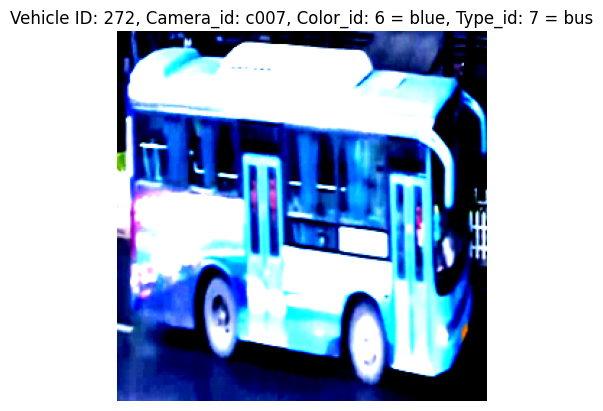

In [15]:
import torch
import random
import matplotlib.pyplot as plt

def show_random_image(dataset):
    # Estrai un indice casuale
    random_idx = random.randint(0, len(dataset) - 1)

    # Recupera l'immagine e l'etichetta corrispondente
    image, labels = dataset[random_idx]
    vehicle_id = labels["vehicle_id"]
    camera_id = labels["camera_id"]
    color_id = labels["color_id"]
    type_id = labels["type_id"]

    # Se l'immagine è un tensore (torch.Tensor), convertila in formato PIL
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()  # Cambia l'ordine dei canali per matplotlib

    # Stampa l'immagine con le etichette
    plt.imshow(image)
    plt.title(f"Vehicle ID: {vehicle_id}, Camera_id: {camera_id}, Color_id: {color_id} = {color_mapping[color_id]}, Type_id: {type_id} = {type_mapping[type_id]}")
    plt.axis('off')
    plt.show()

# Esegui la funzione sul train_dataset
show_random_image(train_dataset)


## 3.2 Creazione dei DataLoader
In PyTorch il **DataLoader** è una classe che permette di iterare in modo efficiente sul dataset, suddividendolo in mini-batch.
Un **batch** è un sottinsieme del dataset completo che viene elaborato dal modello in una singola iterazione.

**DataLoader()**:
* Dataset: il dataset che deve essere iterato
* batch_size: Numero di immagini per batch
* shuffle: Mescola i dati (True/False)
* Numero di thread per il caricamento parallelo dei dati

In [16]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# 4. Caricamento del modello

Il modello caricato è il ResNet50

In [17]:
import torch
import torch.nn as nn
from torchvision import models

class MultiOutputResNet50(nn.Module):
    def __init__(self, num_vehicle_ids, num_colors, num_types):
        super(MultiOutputResNet50, self).__init__()
        # CArica il modello ResNet50 pre-allenato su ImageNet
        self.backbone = models.resnet50(pretrained=True)

        # Rimuovi il layer finale (fc) originale di ResNet50
        # ResNet 50 ha una struttura con più blocchi di cui l'ultimo è un layer lineare
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])

        # "Teste" per le diverse classificazioni
        self.fc_vehicle = nn.Linear(2048, num_vehicle_ids)
        self.fc_color = nn.Linear(2048, num_colors)
        self.fc_type = nn.Linear(2048, num_types)

    def forward(self, x):
        # Estrae le feature con il backbone (ResNet50)
        # L'input x ha dimensione: [batch_size, 3, H, W]
        features = self.backbone(x)

        # Appiattisce le feature da 4D a 2D: [batch_size, 2048]
        features = torch.flatten(features, 1)  # Appiattisci il vettore

        # Calcola i logit per ciascuna delle tre teste
        vehicle_logits = self.fc_vehicle(features)
        color_logits = self.fc_color(features)
        type_logits = self.fc_type(features)

        return vehicle_logits, color_logits, type_logits

`pandas.DataFrame.nunique()`: Conta il numero di elementi distinti in uno specifico asse (default: axis=0)

In [18]:
# Numero di classi per ogni tipo di etichetta
num_vehicle_ids_train = train_labels_df["vehicle_id"].nunique()
num_vehicle_ids_test = test_labels_df["vehicle_id"].nunique()
total_num_vehicle_ids = num_vehicle_ids_train + num_vehicle_ids_test
num_colors = train_labels_df["color_id"].nunique()+1
num_types = train_labels_df["type_id"].nunique()+1

# Inizializza il modello
model = MultiOutputResNet50(total_num_vehicle_ids, num_colors, num_types)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)  # Sposta il modello sul dispositivo

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


MultiOutputResNet50(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

# 5. Definizione di loss function e optimizer

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 6. Definizione di train e eval del modello

In [20]:
from tqdm import tqdm

def train_model(model, dataloader, loss_fn, optimizer, num_epochs=5):
  model.train()

  for epoch in range(num_epochs):  # Numero di epoche
    running_loss = 0.0

    for images, labels in tqdm(dataloader):
        images = images.to(device)
        vehicle_labels = labels["vehicle_id"].to(device)
        color_labels = labels["color_id"].to(device)
        type_labels = labels["type_id"].to(device)

        # Azzeriamo i gradienti
        optimizer.zero_grad()

        # Forward pass
        vehicle_logits, color_logits, type_logits = model(images)

        # Calcolo della perdita
        loss_vehicle = loss_fn(vehicle_logits, vehicle_labels)
        loss_color = loss_fn(color_logits, color_labels)
        loss_type = loss_fn(type_logits, type_labels)

        loss = loss_vehicle + loss_color + loss_type  # Perdita totale
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

In [22]:
def evaluate_model(model, dataloader):
  model.eval()
  correct_vehicle = 0
  correct_color = 0
  correct_type = 0

  with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        vehicle_labels = labels["vehicle_id"].to(device)
        color_labels = labels["color_id"].to(device)
        type_labels = labels["type_id"].to(device)

        # Forward pass
        vehicle_logits, color_logits, type_logits = model(images)

        # Calcolo delle predizioni
        _, vehicle_preds = torch.max(vehicle_logits, 1)
        _, color_preds = torch.max(color_logits, 1)
        _, type_preds = torch.max(type_logits, 1)

        # Aggiorna le metriche
        correct_vehicle += (vehicle_preds == vehicle_labels).sum().item()
        correct_color += (color_preds == color_labels).sum().item()
        correct_type += (type_preds == type_labels).sum().item()

  print(f"Vehicle Accuracy: {correct_vehicle / len(test_labels_df):.4f}")
  print(f"Color Accuracy: {correct_color / len(test_labels_df):.4f}")
  print(f"Type Accuracy: {correct_type / len(test_labels_df):.4f}")

# 7. Training del modello

In [24]:
from torch.utils.data import DataLoader

# Avvia il training
train_model(model, train_loader, loss_fn, optimizer, num_epochs=10)

# Valuta il modello
evaluate_model(model, test_loader)

Epoch 1/10: 100%|██████████| 1180/1180 [07:52<00:00,  2.50it/s]


Epoch 1, Loss: 4.7139, Accuracy - Vehicle: 0.1528, Color: 0.8813, Type: 0.8070


Epoch 2/10: 100%|██████████| 1180/1180 [07:51<00:00,  2.50it/s]


Epoch 2, Loss: 2.3024, Accuracy - Vehicle: 0.4636, Color: 0.9466, Type: 0.9222


Epoch 3/10: 100%|██████████| 1180/1180 [07:51<00:00,  2.50it/s]


Epoch 3, Loss: 1.1297, Accuracy - Vehicle: 0.7177, Color: 0.9698, Type: 0.9610


Epoch 4/10: 100%|██████████| 1180/1180 [07:51<00:00,  2.50it/s]


Epoch 4, Loss: 0.6549, Accuracy - Vehicle: 0.8349, Color: 0.9782, Type: 0.9781


Epoch 5/10: 100%|██████████| 1180/1180 [07:51<00:00,  2.51it/s]


Epoch 5, Loss: 0.4366, Accuracy - Vehicle: 0.8923, Color: 0.9857, Type: 0.9832


Epoch 6/10: 100%|██████████| 1180/1180 [07:52<00:00,  2.50it/s]


Epoch 6, Loss: 0.3154, Accuracy - Vehicle: 0.9233, Color: 0.9881, Type: 0.9884


Epoch 7/10: 100%|██████████| 1180/1180 [07:51<00:00,  2.50it/s]


Epoch 7, Loss: 0.2487, Accuracy - Vehicle: 0.9399, Color: 0.9898, Type: 0.9907


Epoch 8/10: 100%|██████████| 1180/1180 [07:50<00:00,  2.51it/s]


Epoch 8, Loss: 0.1998, Accuracy - Vehicle: 0.9528, Color: 0.9912, Type: 0.9916


Epoch 9/10: 100%|██████████| 1180/1180 [07:49<00:00,  2.51it/s]


Epoch 9, Loss: 0.1642, Accuracy - Vehicle: 0.9613, Color: 0.9939, Type: 0.9929


Epoch 10/10: 100%|██████████| 1180/1180 [07:49<00:00,  2.51it/s]

Epoch 10, Loss: 0.1401, Accuracy - Vehicle: 0.9679, Color: 0.9947, Type: 0.9934


Vehicle Accuracy: 0.0000
Color Accuracy: 0.9275
Type Accuracy: 0.8854


# 8. Salvataggio modello

In [28]:
# Percorso dove salvare il modello
model_save_path = "/rained_model.pth"

# Salva i pesi del modello
torch.save(model.state_dict(), model_save_path)
print(f"Modello salvato in {model_save_path}")

Modello salvato in /rained_model.pth


# 9. Test del Modello

Test Image 1:
Vehicle ID - Predicted: 556, Actual: 556
Color ID   - Predicted: 4 = gray, Actual: 4 = gray
Type ID    - Predicted: 1 = sedan, Actual: 1 = sedan


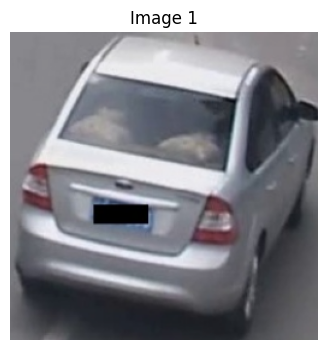

--------------------------------------------------
Test Image 2:
Vehicle ID - Predicted: 564, Actual: 564
Color ID   - Predicted: 4 = gray, Actual: 4 = gray
Type ID    - Predicted: 1 = sedan, Actual: 1 = sedan


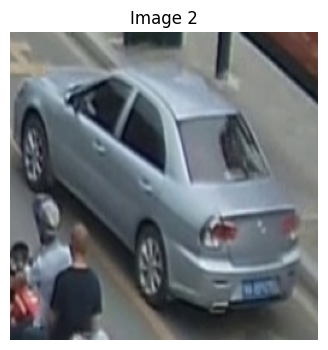

--------------------------------------------------
Test Image 3:
Vehicle ID - Predicted: 94, Actual: 94
Color ID   - Predicted: 3 = green, Actual: 3 = green
Type ID    - Predicted: 6 = pickup, Actual: 6 = pickup


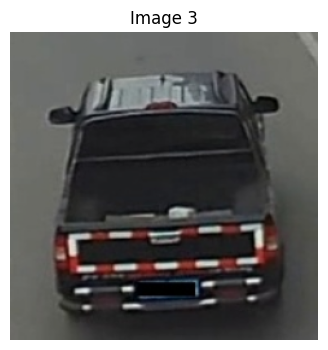

--------------------------------------------------
Test Image 4:
Vehicle ID - Predicted: 425, Actual: 425
Color ID   - Predicted: 4 = gray, Actual: 4 = gray
Type ID    - Predicted: 2 = suv, Actual: 2 = suv


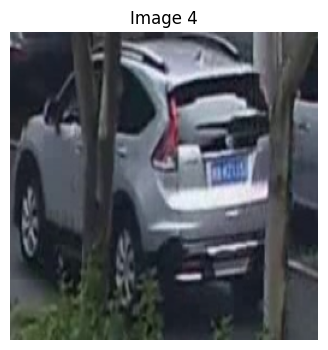

--------------------------------------------------
Test Image 5:
Vehicle ID - Predicted: 732, Actual: 732
Color ID   - Predicted: 10 = black, Actual: 10 = black
Type ID    - Predicted: 1 = sedan, Actual: 1 = sedan


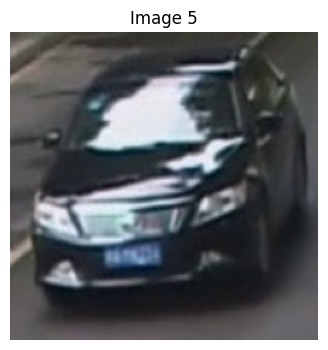

--------------------------------------------------
Test Image 6:
Vehicle ID - Predicted: 304, Actual: 304
Color ID   - Predicted: 7 = white, Actual: 7 = white
Type ID    - Predicted: 4 = hatchback, Actual: 4 = hatchback


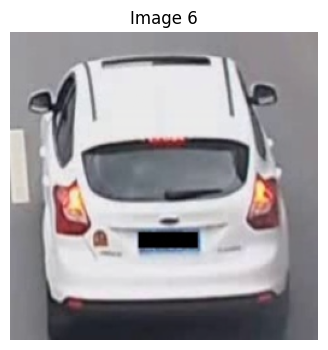

--------------------------------------------------
Test Image 7:
Vehicle ID - Predicted: 580, Actual: 580
Color ID   - Predicted: 10 = black, Actual: 10 = black
Type ID    - Predicted: 2 = suv, Actual: 2 = suv


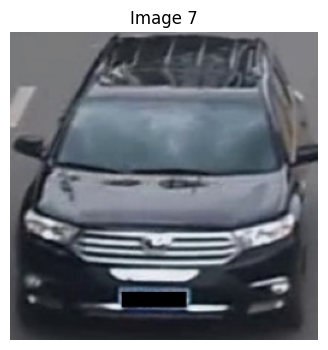

--------------------------------------------------
Test Image 8:
Vehicle ID - Predicted: 587, Actual: 587
Color ID   - Predicted: 10 = black, Actual: 10 = black
Type ID    - Predicted: 2 = suv, Actual: 2 = suv


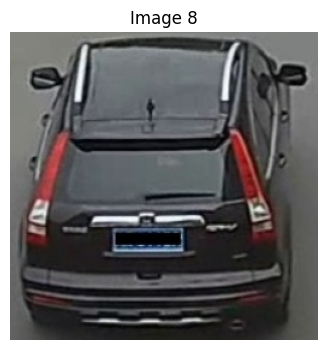

--------------------------------------------------
Test Image 9:
Vehicle ID - Predicted: 424, Actual: 424
Color ID   - Predicted: 4 = gray, Actual: 4 = gray
Type ID    - Predicted: 2 = suv, Actual: 2 = suv


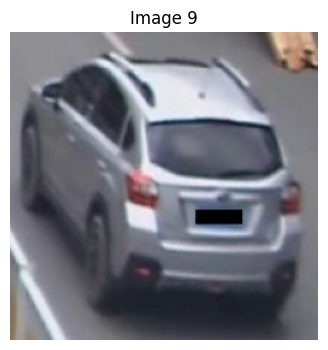

--------------------------------------------------
Test Image 10:
Vehicle ID - Predicted: 225, Actual: 225
Color ID   - Predicted: 8 = golden, Actual: 8 = golden
Type ID    - Predicted: 1 = sedan, Actual: 1 = sedan


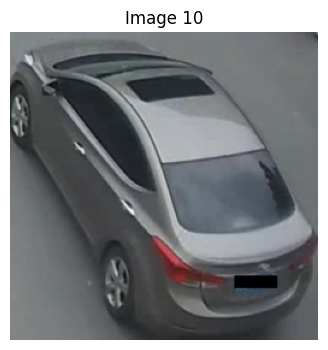

--------------------------------------------------


In [52]:
import random
from termcolor import colored
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def test_model_on_random_images(model, dataloader, device=device, num_images=10):
    """
    Testa il modello su un numero di immagini casuali, stampa se la predizione è corretta o errata
    e visualizza ogni immagine.

    Args:
        model: Il modello PyTorch da testare.
        dataloader: DataLoader per il set di test.
        device: 'cuda' o 'cpu'.
        num_images: Numero di immagini da testare (default 10).
    """
    model.eval()  # Imposta il modello in modalità di valutazione
    random.seed(42)  # Per riproducibilità
    images_checked = 0
    unnormalize = transforms.Compose([
        transforms.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                             std=[1 / 0.229, 1 / 0.224, 1 / 0.225])
    ])  # Trasformazione per riportare l'immagine originale

    with torch.no_grad():  # Disabilita il calcolo dei gradienti
        for images, labels in dataloader:
            # Sposta immagini e etichette su device
            images = images.to(device)
            vehicle_labels = labels["vehicle_id"].to(device)
            color_labels = labels["color_id"].to(device)
            type_labels = labels["type_id"].to(device)

            # Predizione del modello
            vehicle_logits, color_logits, type_logits = model(images)
            _, predicted_vehicle = vehicle_logits.max(1)
            _, predicted_color = color_logits.max(1)
            _, predicted_type = type_logits.max(1)

            # Iteriamo sulle immagini di questo batch
            for i in range(images.size(0)):
                if images_checked >= num_images:
                    return  # Stop quando abbiamo testato abbastanza immagini

                # Estrai l'immagine corrente e de-normalizzala per la visualizzazione
                img = images[i].cpu()
                img = unnormalize(img)
                img = img.permute(1, 2, 0).clamp(0, 1).numpy()  # Cambia ordine dimensioni per plt.imshow

                # Stampa informazioni
                print(f"Test Image {images_checked + 1}:")

                # Vehicle ID
                print(f"Vehicle ID - Predicted: {predicted_vehicle[i].item()}, Actual: {vehicle_labels[i].item()}")

                # Color ID
                print(f"Color ID   - Predicted: {predicted_color[i].item()} = {color_mapping[predicted_color[i].item()]}, Actual: {color_labels[i].item()} = {color_mapping[color_labels[i].item()]}")

                # Type ID
                print(f"Type ID    - Predicted: {predicted_type[i].item()} = {type_mapping[predicted_type[i].item()]}, Actual: {type_labels[i].item()} = {type_mapping[type_labels[i].item()]}")

                # Visualizza l'immagine
                plt.figure(figsize=(4, 4))
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Image {images_checked + 1}")
                plt.show()

                print("-" * 50)  # Divider tra le immagini
                images_checked += 1

test_model_on_random_images(model, train_loader)

Test Image 1:
Vehicle ID - Predicted: 1, Actual: 2
Color ID   - Predicted: 1 = yellow, Actual: 1 = yellow
Type ID    - Predicted: 4 = hatchback, Actual: 4 = hatchback


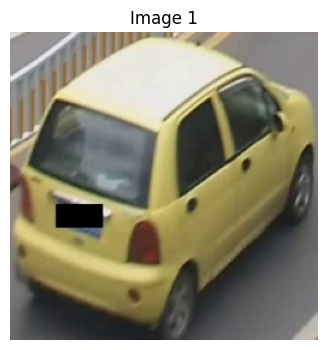

--------------------------------------------------
Test Image 2:
Vehicle ID - Predicted: 1, Actual: 2
Color ID   - Predicted: 1 = yellow, Actual: 1 = yellow
Type ID    - Predicted: 4 = hatchback, Actual: 4 = hatchback


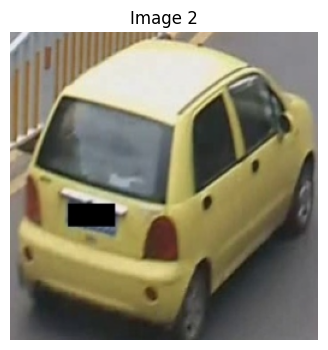

--------------------------------------------------
Test Image 3:
Vehicle ID - Predicted: 1, Actual: 2
Color ID   - Predicted: 1 = yellow, Actual: 1 = yellow
Type ID    - Predicted: 4 = hatchback, Actual: 4 = hatchback


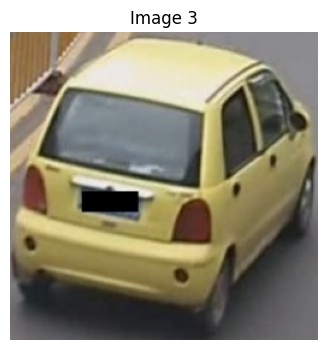

--------------------------------------------------
Test Image 4:
Vehicle ID - Predicted: 1, Actual: 2
Color ID   - Predicted: 1 = yellow, Actual: 1 = yellow
Type ID    - Predicted: 4 = hatchback, Actual: 4 = hatchback


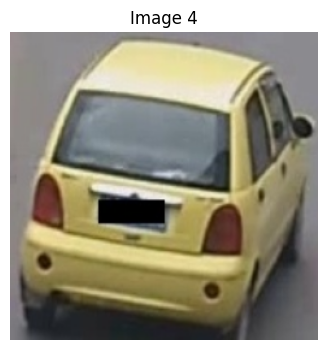

--------------------------------------------------
Test Image 5:
Vehicle ID - Predicted: 1, Actual: 2
Color ID   - Predicted: 1 = yellow, Actual: 1 = yellow
Type ID    - Predicted: 4 = hatchback, Actual: 4 = hatchback


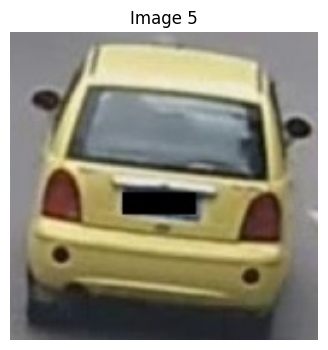

--------------------------------------------------
Test Image 6:
Vehicle ID - Predicted: 1, Actual: 2
Color ID   - Predicted: 1 = yellow, Actual: 1 = yellow
Type ID    - Predicted: 4 = hatchback, Actual: 4 = hatchback


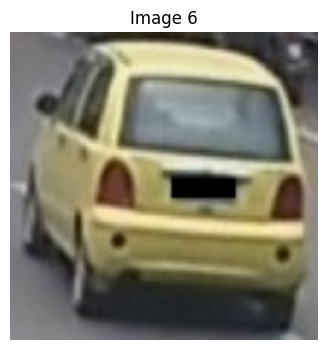

--------------------------------------------------
Test Image 7:
Vehicle ID - Predicted: 1, Actual: 2
Color ID   - Predicted: 1 = yellow, Actual: 1 = yellow
Type ID    - Predicted: 4 = hatchback, Actual: 4 = hatchback


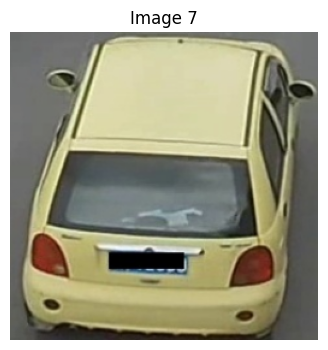

--------------------------------------------------
Test Image 8:
Vehicle ID - Predicted: 1, Actual: 2
Color ID   - Predicted: 1 = yellow, Actual: 1 = yellow
Type ID    - Predicted: 4 = hatchback, Actual: 4 = hatchback


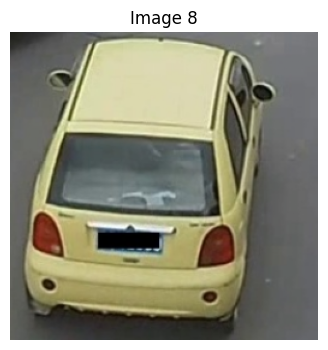

--------------------------------------------------
Test Image 9:
Vehicle ID - Predicted: 1, Actual: 2
Color ID   - Predicted: 1 = yellow, Actual: 1 = yellow
Type ID    - Predicted: 4 = hatchback, Actual: 4 = hatchback


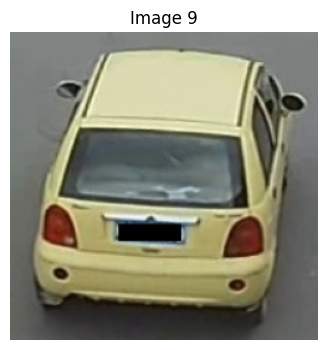

--------------------------------------------------
Test Image 10:
Vehicle ID - Predicted: 1, Actual: 2
Color ID   - Predicted: 1 = yellow, Actual: 1 = yellow
Type ID    - Predicted: 4 = hatchback, Actual: 4 = hatchback


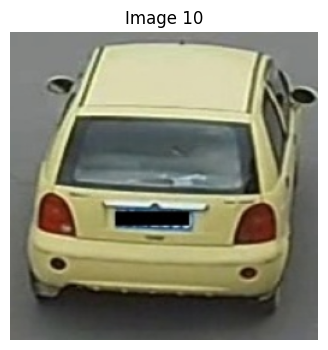

--------------------------------------------------


In [53]:
test_model_on_random_images(model, test_loader)

In [ ]:
import torch

# Specifica il percorso dove salvare il file
checkpoint_path = "/content/model_checkpoint.pth"

# Salva il modello e lo stato
torch.save({
    'epoch': num_epochs,  # Numero di epoche completate
    'model_state_dict': model.state_dict(),  # Stato del modello
    'optimizer_state_dict': optimizer.state_dict(),  # Stato dell'ottimizzatore
    'loss': loss  # Ultima perdita registrata
}, checkpoint_path)

print(f"Checkpoint salvato in: {checkpoint_path}")